# Libraries

In [1]:
import requests

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


pd.set_option('display.max_columns', None) # display all columns in DF

# Import data

In [2]:
df = pd.read_csv('output_regression_org.csv', sep = '~')
df

,date,unique_id,generic_units_reimbursed_sum,generic_total_amount_reimbursed_adj_sum,units_reimbursed_sum,total_amount_reimbursed_adj_sum,col_temp,running_count_generics,number_of_first_entrance,running_count_from_fourth_entrance,running_count_from_third_entrance,running_count_from_second_entrance,running_count_from_start,first_nda,labeler_name,labeler_name_count,marketing_category,brand_name,generic_name,pharm_class,is_original_packager,ATC (level 1),units_reimbursed,total_amount_reimbursed_adj,price_per_unit_adj,unique_substitute,running_count_unique_substitute,running_count_event,generic_share_units_reimbursed_sum,generic_share_total_amount_reimbursed_adj_sum
0,1991-01-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,18592.0,50898.137194,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,Genito Urinary System And Sex Hormones,18592.0,50898.137194,2.737636,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
1,1991-04-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,18839.0,51893.063430,2.0,0,1.0,0.0,0.0,0.0,2.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,Genito Urinary System And Sex Hormones,18839.0,51893.063430,2.754555,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
2,1991-07-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,28418.0,76648.158195,3.0,0,1.0,0.0,0.0,0.0,3.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,Genito Urinary System And Sex Hormones,28418.0,76648.158195,2.697169,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
3,1991-10-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,34263.0,88082.844442,4.0,0,1.0,0.0,0.0,0.0,4.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,Genito Urinary System And Sex Hormones,34263.0,88082.844442,2.570786,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
4,1992-01-01,acetohydroxamic acid-tablet-oral-250 mg/1,0.0,0.0,32343.0,80168.781465,5.0,0,1.0,0.0,0.0,0.0,5.0,1.0,Mission Pharmacal Company,1,NDA,Lithostat,ACETOHYDROXAMIC ACID,"['Urease Inhibitor [EPC]', 'Urease Inhibitors ...",True,Genito Urinary System And Sex Hormones,32343.0,80168.781465,2.478706,Urease Inhibitor [EPC]-ORAL-Urease Inhibitors ...,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83484,2021-01-01,ivacaftor-granule-oral-25 mg/1,0.0,0.0,616.0,260501.188638,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,Vertex Pharmaceuticals Incorporated,1,NDA,Kalydeco,IVACAFTOR,['Chloride Channel Activation Potentiators [Mo...,True,Respiratory System,616.0,260501.188638,422.891540,Cystic Fibrosis Transmembrane Conductance Regu...,6.0,NaN,0.0,0.0
83485,2021-01-01,lanthanum carbonate-powder-oral-750 mg/1,0.0,0.0,3420.0,37183.651315,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,"Takeda Pharmaceuticals America, Inc.",1,NDA,Fosrenol,LANTHANUM CARBONATE,"['Phosphate Binder [EPC]', 'Phosphate Chelatin...",True,Various,3420.0,37183.651315,10.872413,Phosphate Binder [EPC]-ORAL-Phosphate Chelatin...,10.0,NaN,0.0,0.0
83486,2021-01-01,levonorgestrel-patch-transdermal-2.6 mg/1,0.0,0.0,1569.0,86841.963374,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,"Agile Therapeutics, Inc.",1,NDA,Twirla,LEVONORGESTREL,"['Estrogen Receptor Agonists [MoA]', 'Estrogen...",True,Genito Urinary System And Sex Hormones,1569.0,86841.963374,55.348606,Estrogen [EPC]-TRANSDERMAL-Estrogen Receptor A...,56.0,NaN,0.0,0.0
83487,2021-01-01,sodium sulfate-tablet-oral-17.75 g/1,0.0,0.0,18482.0,116215.796805,1.0,0,1.0,0.0,0.0,0.0,1.0,1.0,"Braintree Laboratories, Inc.",1,NDA,SUTAB,SODIUM SULFATE,"['Calculi Dissolution Agent [EPC]', 'Increased...",True,Alimentary Tract And Metabolism,18482.0,116215.796805,6.288053,Calculi Disso

# Number of producer versus price per. unit

In [3]:
df_figure_1 = df.groupby("labeler_name_count")["price_per_unit_adj"].mean()
df_figure_1 = pd.DataFrame(df_figure_1.reset_index())
df_figure_1['ln_price_per_unit_adj'] = np.log(df_figure_1['price_per_unit_adj'])
#df_figure_1

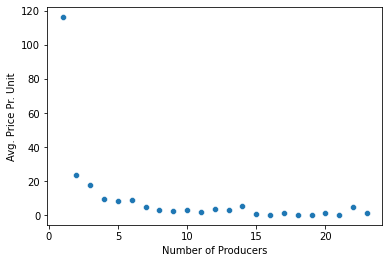

In [4]:
Intro_fig = sns.scatterplot(x="labeler_name_count", y="price_per_unit_adj", data=df_figure_1)
Intro_fig.set(xlabel = "Number of Producers", ylabel = "Avg. Price Pr. Unit")
Intro_fig = Intro_fig.get_figure()
#Intro_fig.savefig("Avg_price_and_number_of_producers.png")

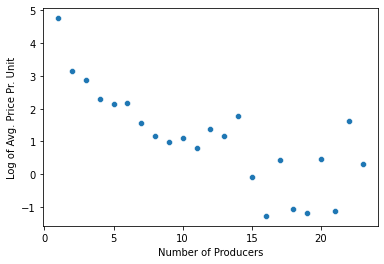

In [5]:
Intro_fig = sns.scatterplot(x="labeler_name_count", y="ln_price_per_unit_adj", data=df_figure_1)
Intro_fig.set(xlabel = "Number of Producers", ylabel = "Log of Avg. Price Pr. Unit")
Intro_fig = Intro_fig.get_figure()
#Intro_fig.savefig("log_of_avg_price_and_number_of_producers.png")

Creating the same figure where the unique drugs are grouped by ATC

In [6]:
df_figure_1_atc = df.groupby(["labeler_name_count", 'ATC (level 1)'])["price_per_unit_adj"].mean()
df_figure_1_atc = pd.DataFrame(df_figure_1_atc.reset_index())
df_figure_1_atc['ln_price_per_unit_adj'] = np.log(df_figure_1_atc['price_per_unit_adj'])
#df_figure_1_atc

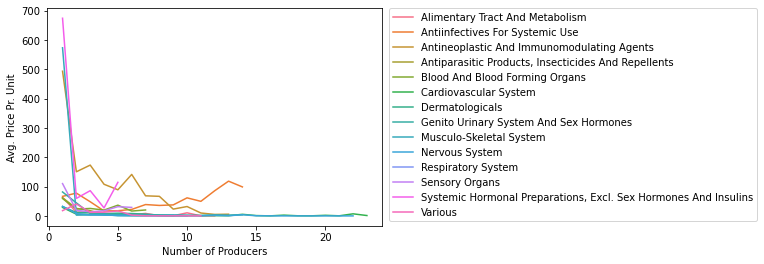

In [7]:
Intro_fig = sns.lineplot(x="labeler_name_count", y="price_per_unit_adj", hue="ATC (level 1)", data=df_figure_1_atc)
Intro_fig.set(xlabel = "Number of Producers", ylabel = "Avg. Price Pr. Unit")
Intro_fig.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
Intro_fig = Intro_fig.get_figure()
#Intro_fig.savefig("Avg_price_and_number_of_producers_ATC.png")

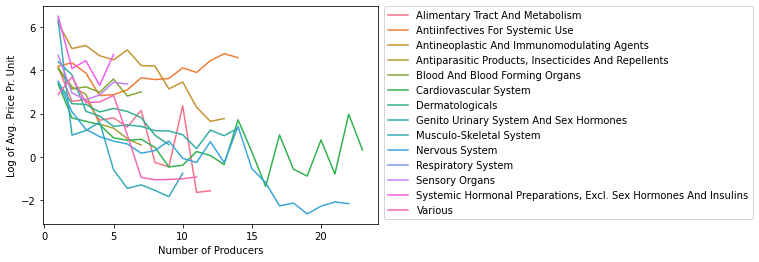

In [8]:
Intro_fig = sns.lineplot(x="labeler_name_count", y="ln_price_per_unit_adj", hue="ATC (level 1)", data=df_figure_1_atc)
Intro_fig.set(xlabel = "Number of Producers", ylabel = "Log of Avg. Price Pr. Unit")
Intro_fig.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
Intro_fig = Intro_fig.get_figure()
#Intro_fig.savefig("Log_of_avg_price_and_number_of_producers_ATC.png")

# Specific drug figure

In [9]:
df_figure = df.loc[df['unique_id'] == 'alprazolam-tablet-oral-.5 mg/1']
df_figure['date'] = pd.to_datetime(df_figure['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

<ipython-input-9-d9d264bab53f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_figure['date'] = pd.to_datetime(df_figure['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')


In [10]:
df_figure = df_figure.groupby(['date', 'generic_name', 'labeler_name', 'ATC (level 1)'])['price_per_unit_adj'].mean()
df_figure = df_figure.reset_index()
df_figure['ln_price_per_unit_adj'] = np.log(df_figure['price_per_unit_adj'])

In [11]:
df_figure

,date,generic_name,labeler_name,ATC (level 1),price_per_unit_adj,ln_price_per_unit_adj
0,1991-01-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,Nervous System,2.122635,0.752658
1,1991-04-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,Nervous System,2.233509,0.803574
2,1991-07-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,Nervous System,2.123210,0.752929
3,1991-10-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,Nervous System,2.170762,0.775078
4,1992-01-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,Nervous System,2.185910,0.782032
...,...,...,...,...,...,...
506,2021-01-01,ALPRAZOLAM,"Breckenridge Pharmaceutical, Inc.",Nervous System,0.114706,-2.165384
507,2021-01-01,ALPRAZOLAM,Greenstone LLC,Nervous System,0.136088,-1.994455
508,2021-01-01,ALPRAZOLAM,Par Pharmaceutical,Nervous System,0.130488,-2.036475
509,2021-01-01,ALPRAZOLAM,Pharmacia & Upjohn Company LLC,Nervous System,5.150481,1.639090


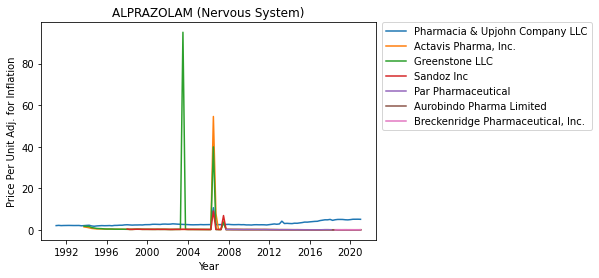

In [12]:
p = sns.lineplot(data = df_figure, x = 'date', y = 'price_per_unit_adj', hue = 'labeler_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Price Per Unit Adj. for Inflation', title = df_figure['generic_name'][0] + ' (' + df_figure['ATC (level 1)'][0] + ')' )
p = p.get_figure()
#p.savefig("Fig_one_drug.png",bbox_inches="tight")

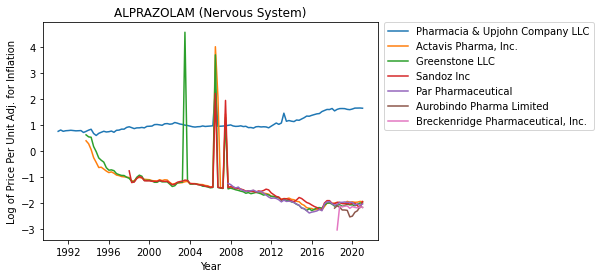

In [13]:
p = sns.lineplot(data = df_figure, x = 'date', y = 'ln_price_per_unit_adj', hue = 'labeler_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Log of Price Per Unit Adj. for Inflation', title = df_figure['generic_name'][0] + ' (' + df_figure['ATC (level 1)'][0] + ')' )
p = p.get_figure()
#p.savefig("Fig_one_drug_log.png", bbox_inches="tight")

# Event figure - average and log of average

In [15]:
df_fig_event = df.dropna(subset = ['running_count_event'])
df_fig_event = df_fig_event.groupby('running_count_event')['price_per_unit_adj'].mean()
df_fig_event = df_fig_event.reset_index()
df_fig_event['ln_price_per_unit_adj'] = np.log(df_fig_event['price_per_unit_adj'])

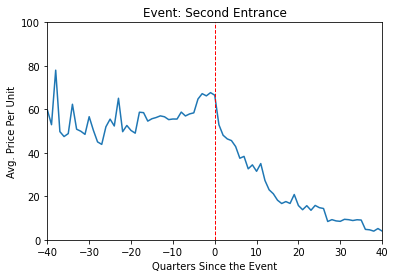

In [16]:
p_event = sns.lineplot(data = df_fig_event, x = 'running_count_event', y = 'price_per_unit_adj')
p_event.set(xlabel = 'Quarters Since the Event', ylabel = 'Avg. Price Per Unit', title ='Event: Second Entrance')
plt.axvline(0, color = "red", lw = 1, ls='--')
plt.xlim([-40, 40])
plt.ylim([0, 100])
p_event = p_event.get_figure()
#p_event.savefig("Fig_event.png", bbox_inches="tight")

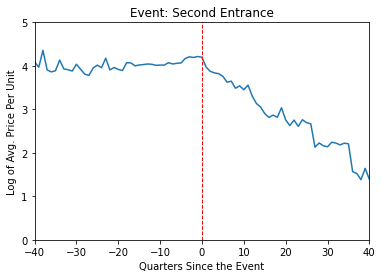

In [17]:
p_event = sns.lineplot(data = df_fig_event, x = 'running_count_event', y = 'ln_price_per_unit_adj')
p_event.set(xlabel = 'Quarters Since the Event', ylabel = 'Log of Avg. Price Per Unit', title ='Event: Second Entrance')
plt.axvline(0, color = "red", lw = 1, ls='--')
plt.xlim([-40, 40])
plt.ylim([0, 5])
p_event = p_event.get_figure()
#p_event.savefig("Fig_event_log.png", bbox_inches="tight")

Creating the same figure where the unique drugs are grouped by ATC

In [18]:
df_fig_event_atc = df.dropna(subset = ['running_count_event'])
df_fig_event_atc = df_fig_event_atc.groupby(['running_count_event', 'ATC (level 1)'])['price_per_unit_adj'].mean()
df_fig_event_atc = df_fig_event_atc.reset_index()
df_fig_event_atc['ln_price_per_unit_adj'] = np.log(df_fig_event_atc['price_per_unit_adj'])

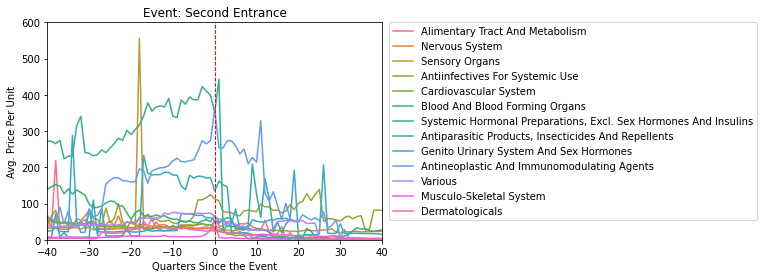

In [19]:
p_event_atc = sns.lineplot(data = df_fig_event_atc, x = 'running_count_event', y = 'price_per_unit_adj', hue = 'ATC (level 1)')
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p_event_atc.set(xlabel = 'Quarters Since the Event', ylabel = 'Avg. Price Per Unit', title ='Event: Second Entrance')
plt.axvline(0, color = "red", lw = 1, ls='--')
plt.xlim([-40, 40])
plt.ylim([0, 600])
p_event_atc = p_event_atc.get_figure()
#p_event.savefig("Fig_event_atc.png", bbox_inches="tight")

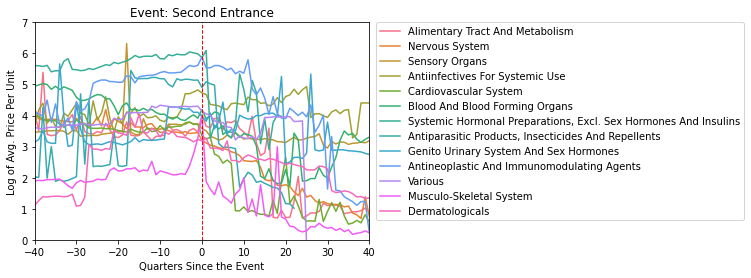

In [20]:
p_event_atc = sns.lineplot(data = df_fig_event_atc, x = 'running_count_event', y = 'ln_price_per_unit_adj', hue = 'ATC (level 1)')
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p_event_atc.set(xlabel = 'Quarters Since the Event', ylabel = 'Log of Avg. Price Per Unit', title ='Event: Second Entrance')
plt.axvline(0, color = "red", lw = 1, ls='--')
plt.xlim([-40, 40])
plt.ylim([0, 7])
p_event_atc = p_event_atc.get_figure()
#p_event.savefig("Fig_event_log_atc.png", bbox_inches="tight")